<a href="https://colab.research.google.com/github/Shaddy-joker/GAN/blob/main/CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This code is an adaptation of the orignal code by  https://github.com/junyanz?tab=repositories

The dataset used is the same dataset used in the orignal paper
Dataset: https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/
Link to the paper:

In [ ]:
#importing all the required libraries
import matplotlib.pyplot as plt
from random import random
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU, Activation, Concatenate
import os
from os import listdir
from numpy import asarray
from numpy import vstack
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.utils import resample

In [ ]:
# installing the package of instance normalization as per the instruction provided in the paper
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-titonb_6
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-titonb_6
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=89ad74156b0fea531011d3aec4cefac77667ff7ed2a1ea64b29397c4f856a062
  Stored in directory: /tmp/pip-ephem-wheel-cache-olmzy3bw/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [ ]:
#define discriminator
def discriminator (image_shape):

    model= Sequential()
    initializer= RandomNormal(stddev=0.05)
    input_image= Input(shape=image_shape)

    model.add(Conv2D(64,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer, input_shape= image_shape))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(128,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(256,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2D(512,(4,4), strides=(2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(LeakyReLU(alpha=0.2))

    model.compile(loss='mse', optimizer=Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])

    return model

In [ ]:
#defining the residual network block
def resnet_block (num_filters, input_layer):
    initializer=RandomNormal(stddev=0.05)
    model= Sequential()

    model.add(Conv2D(num_filters,(3,3), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    model.add(Conv2D(num_filters,(3,3), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    return model


In [ ]:
#defining the generator
def generator( image_shape, num_resnet=9):
    model= Sequential()
    initializer= RandomNormal(stddev=0.05)
    input_image= Input(shape=image_shape)

    model.add(Conv2D(64,(7,7), padding="same", kernel_initializer=initializer, input_shape=image_shape))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    model.add(Conv2D(128,(3,3),strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    model.add(Conv2D(256,(3,3),strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    for _ in range (num_resnet):
        resnet_block(256, model)

    model.add(Conv2DTranspose(128,(3,3), strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    model.add(Conv2DTranspose(64,(3,3), strides= (2,2), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("relu"))

    model.add(Conv2D(3,(7,7), padding="same", kernel_initializer=initializer))
    model.add(InstanceNormalization(axis=-1))
    model.add(Activation("tanh"))

    return model

In [ ]:
#Combine generator and discriminator blocks
def composite_model (generator_1, discriminator, generator_2, image_shape):

    generator_1.trainable= True
    discriminator.trainable= False
    generator_2.trainable= False

    #adversarial loss
    input_gen= Input(shape=image_shape)
    gen1_out= generator_1(input_gen)
    output_d= discriminator(gen1_out)

    #identity loss
    input_id= Input(shape=image_shape)
    output_id= generator_1(input_id)

    #cycle loss- forward
    output_f= generator_1(gen1_out)

    #cycle loss- backward
    gen2_out= generator_2(input_id)
    output_b= generator_1(gen2_out)

    model= Model([input_gen, input_id], [output_d, output_id, output_f, output_b])

    opt= Adam(learning_rate=0.0002, beta_1=0.5)

    model.compile(loss=["mse", "mae", "mae", "mae"],
                  loss_weights=[1,5,10,10],
                  optimizer=opt)

    return model

In [ ]:
# function for generating real examples
def generate_real_samples(dataset, num_samples, patch_shape):

    ix = np.random.randint(0, dataset.shape[0], num_samples)

    X = dataset[ix]

    y = np.ones((num_samples, patch_shape, patch_shape, 1))
    return X,y

In [ ]:
# function for generating fake examples
def generate_fake_samples(generator, dataset, patch_shape):

    X= generator.predict(dataset)

    y= np.zeros((len(X), patch_shape, patch_shape, 1))

    return X,y

In [ ]:
# save current network weights
def save_models(step, generator_AtoB, generator_BtoA):
    # save the first generator model
    filename1 = 'generator_AtoB_%06d.h5' % (step+1)
    generator_AtoB.save(filename1)
    # save the second generator model
    filename2 = 'generatorl_BtoA_%06d.h5' % (step+1)
    generator_BtoA.save(filename2)
    print('>Saved: %s and %s' % (filename1, filename2))

In [ ]:
# save photos generated
def summarize_performance(step, generator, trainX, name, num_samples=5):
    # select a sample of input images
    X_in, _ = generate_real_samples(trainX, num_samples, 0)
    # generate translated images
    X_out, _ = generate_fake_samples(generator, X_in, 0)
    # scale all pixels from [-1,1] to [0,1]
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    # plot real images
    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + i)
        plt.axis('off')
        plt.imshow(X_in[i])
    # plot translated image
    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + num_samples + i)
        plt.axis('off')
        plt.imshow(X_out[i])
    # save plot to file
    filename1 = '%s_generated_plot_%06d.png' % (name, (step+1))
    plt.savefig(filename1)
    plt.close()

In [ ]:
# function for updating the image pool for discriminator
def update_image_pool(pool, images, max_size=50):
    selected =[]
    for image in images:
        if len(pool) < max_size:
            # Adding images to the pool
            pool.append(image)
            selected.append(image)
        elif random() < 0.5:
            # Training images but not added in pool
            selected.append(image)
        else:
            # replace an existing image and use replaced image
            ix = np.random.randint(0, len(pool))
            selected.append(pool[ix])
            pool[ix] = image
    return np.asarray(selected)

In [ ]:
#training
def train (discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, dataset, epochs=10):

    num_epochs, num_batch= epochs, 1
    num_patch = discriminator_A.output_shape[1]

    num_patch = discriminator_A.output_shape[1]

    trainA, trainB = dataset

    poolA, poolB= [], []

    batch_per_epochs = int(len(trainA)/num_batch)

    num_steps= batch_per_epochs* num_epochs

    for i in range (num_steps):
        X_realA, y_realA = generate_real_samples(trainA, num_batch, num_patch)
        X_realB, y_realB = generate_real_samples(trainB, num_batch, num_patch)

        X_fakeA, y_fakeA = generate_fake_samples(generator_BtoA, X_realB, num_patch)
        X_fakeB, y_fakeB = generate_fake_samples(generator_AtoB, X_realA, num_patch)

        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)

        # update generator B->A via the composite model
        g_loss2, _, _, _, _  = composite_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        # update discriminator for A -> [real/fake]
        dA_loss1 = discriminator_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = discriminator_A.train_on_batch(X_fakeA, y_fakeA)

        # update generator A->B via the composite model
        g_loss1, _, _, _, _ = composite_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        # update discriminator for B -> [real/fake]
        dB_loss1 = discriminator_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = discriminator_B.train_on_batch(X_fakeB, y_fakeB)


        if i%100==0:
            print('Iteration>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))



        if (i+1) % (batch_per_epochs * 1) == 0:
            # plot A->B translation
            summarize_performance(i, generator_AtoB, trainA, 'AtoB')
            # plot B->A translation
            summarize_performance(i, generator_BtoA, trainB, 'BtoA')
        if (i+1) % (batch_per_epochs * 5) == 0:
            save_models(i, generator_AtoB, generator_BtoA)

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# dataset path assuming that the data is uploaded in the google drive from where the dataset is accessed
path = os.path.join('gdrive', 'MyDrive','dissertation/monet2photo/')

In [ ]:
os.listdir(path)

['trainB',
 'trainA',
 'testB',
 'testA',
 'uni.jpg',
 'test1.jpg',
 'test2.jpg',
 'test3.jpg']

In [ ]:
#loading images
def load_images(path, size=(256,256)):
    data_list= []

    for filename in listdir(path):
        pixels= load_img(path +filename, target_size=size)
        pixels= img_to_array(pixels)
        data_list.append(pixels)
    return asarray(data_list)

In [ ]:
# load dataset A - Monet paintings
dataA_all= load_images(path +"trainA/")
print("loaded dataA: ",dataA_all.shape)

dataA= resample(dataA_all,
                replace=False,
                n_samples=500,
                random_state=10)

loaded dataA:  (1072, 256, 256, 3)


In [ ]:
# load dataset B - Photos
dataB_all= load_images(path+"trainB/")
print("loaded dataB: ", dataB_all.shape)

dataB= resample(dataB_all,
                replace=False,
                n_samples=500,
                random_state=10)

loaded dataB:  (6294, 256, 256, 3)


In [ ]:
#display random examples from datasets
def samples_plot (num_samples):

    plt.figure(figsize=(num_samples+12,num_samples+7))
    for i in range (num_samples):
        plt.subplot(2,num_samples, 1+i)
        plt.axis("off")
        plt.imshow(dataA[np.random.randint(1,50)].astype('uint8'))
        plt.title("Painting")

    for i in range(num_samples):
        plt.subplot(2, num_samples, 1 + num_samples + i)
        plt.axis("off")
        plt.imshow(dataB[np.random.randint(1,50)].astype('uint8'))
        plt.title("Photo")

    plt.show()

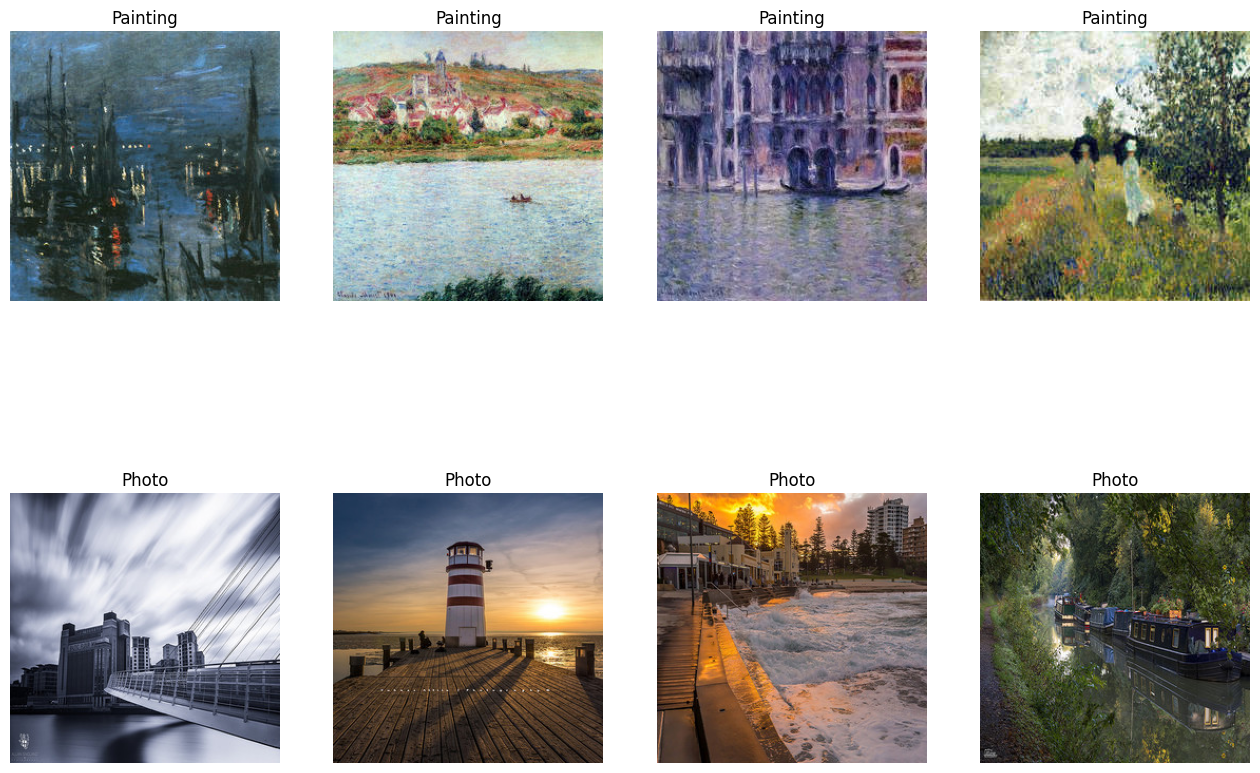

In [ ]:
samples_plot(4)

In [ ]:
data= [dataA, dataB]
print("loaded", data[0].shape, data[1].shape)

loaded (500, 256, 256, 3) (500, 256, 256, 3)


In [ ]:
#function to scale the images to a standard size
def preprocess_data(data):
    X1, X2= data[0], data[1]

    X1= (X1-127.5) /127.5
    X2= (X2-127.5) /127.5

    return [X1,X2]

In [ ]:
#preprocessing the dataset
dataset= preprocess_data(data)

In [ ]:
# printing the structure of the images
image_shape= dataset[0].shape[1:]
print("image shape: ",image_shape)

image shape:  (256, 256, 3)


In [ ]:
#create cycleGAN model
generator_AtoB = generator(image_shape)
generator_BtoA = generator(image_shape)

discriminator_A = discriminator(image_shape)
discriminator_B = discriminator(image_shape)

composite_AtoB= composite_model(generator_AtoB, discriminator_B, generator_BtoA, image_shape)
composite_BtoA= composite_model(generator_BtoA, discriminator_A, generator_AtoB, image_shape)

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
#Train the model with the monet2photo dataset
from datetime import datetime

start1= datetime.now()

train(discriminator_A, discriminator_B, generator_AtoB, generator_BtoA, composite_AtoB, composite_BtoA, dataset, epochs=20)

stop1= datetime.now()

execution_time= stop1-start1

print("Execution time is: ", execution_time )

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step
Iteration>101, dA[0.314,0.087] dB[0.302,0.090] g[8.885,8.114]
1/1 [==============================] - 0s 20ms/step
Iteration>201, dA[0.300,0.118] dB[0.309,0.074] g[7.149,7.217]
1/1 [==============================] - 0s 20ms/step
Iteration>301, dA[0.281,0.099] dB[0.278,0.090] g[8.498,8.305]
1/1 [==============================] - 0s 20ms/step
Iteration>401, dA[0.285,0.077] dB[0.263,0.065] g[8.241,6.997]
1/1 [==============================] - 0s 21ms/step
Iteration>501, dA[0.255,0.069] dB[0.251,0.088] g[4.768,5.364]
1/1 [==============================] - 0s 21ms/step
Iteration>601, dA[0.237,0.086] dB[0.235,0.076] g[5.376,4.898]
1/1 [==============================] - 0s 21ms/step
Iteration>701, dA[0.234,0.082] dB[0.225,0.092] g[7.967,7.841]
1/1 [==============================] - 0s 21ms/step
Iteration>801, dA[0.220,0.080] dB[0.210,0.092] g[5.176,6.124]
1/1 [==============================] 

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 22ms/step
Iteration>2601, dA[0.126,0.124] dB[0.125,0.125] g[7.269,7.829]
1/1 [==============================] - 0s 20ms/step
Iteration>2701, dA[0.126,0.125] dB[0.125,0.125] g[6.665,7.005]
1/1 [==============================] - 0s 21ms/step
Iteration>2801, dA[0.125,0.125] dB[0.125,0.125] g[3.216,3.895]
1/1 [==============================] - 0s 21ms/step
Iteration>2901, dA[0.125,0.125] dB[0.125,0.125] g[5.478,5.089]
1/1 [==============================] - 0s 26ms/step
Iteration>3001, dA[0.125,0.125] dB[0.125,0.125] g[4.174,4.522]
1/1 [==============================] - 0s 21ms/step
Iteration>3101, dA[0.125,0.125] dB[0.125,0.125] g[3.944,3.604]
1/1 [==============================] - 0s 21ms/step
Iteration>3201, dA[0.125,0.125] dB[0.125,0.125] g[4.051,3.825]
1/1 [==============================] - 0s 21ms/step
Iteration>3301, dA[0.125,0.125] dB[0.125,0.125] g[6.547,5.584]
1/1 [========================

>Saved: generator_AtoB_005000.h5 and generatorl_BtoA_005000.h5
Execution time is:  0:23:43.795465


Saving the trained model to drive


In [ ]:
# saving model A to B in drive
model_path = os.path.join(path, 'model/generator_AtoB_005000.h5')
pickle.dump('generator_AtoB_005000.h5', open(model_path, 'wb'))
# saving model B to A in drive
model_path = os.path.join(path, 'model/generatorl_BtoA_005000.h5')
pickle.dump('generatorl_BtoA_005000.h5', open(model_path, 'wb'))



**Visualizing**

In [ ]:
#choosing a  random sample from dataset

from tensorflow.keras.models import load_model

def select_sample (dataset, num_samples):
    ix= np.random.randint(0, dataset.shape[0], num_samples)
    X=dataset[ix]
    return X

In [ ]:
#function for displaying the  generated images
def show_plot(imagesX, imagesY1, imagesY2):
    images = vstack((imagesX, imagesY1, imagesY2))
    titles = ['Real', 'Generated', 'Reconstructed']
    images = (images + 1) / 2.0
    plt.figure(figsize=(15,10))

    for i in range(len(images)):
        plt.subplot(1, len(images), 1 + i)
        plt.axis('off')
        plt.imshow(images[i])
        plt.title(titles[i])
    plt.show()

In [ ]:
# load the images from  dataset and scaling
A_data = resample(dataA_all,
                 replace=False,
                 n_samples=500,
                 random_state=50) #setting a fixed random state to be able to reproduce the results

B_data = resample(dataB_all,
                 replace=False,
                 n_samples=500,
                 random_state=50) #setting a fixed random state to be able to reproduce the results

#Scaling the dataset
A_data = (A_data - 127.5) / 127.5
B_data = (B_data - 127.5) / 127.5

In [ ]:
# load the models

cust= {"InstanceNormalization" : InstanceNormalization}
model_AtoB= load_model("generator_AtoB_005000.h5", cust)
model_BtoA= load_model("generatorl_BtoA_005000.h5", cust)

1/1 [==============================] - 0s 26ms/step


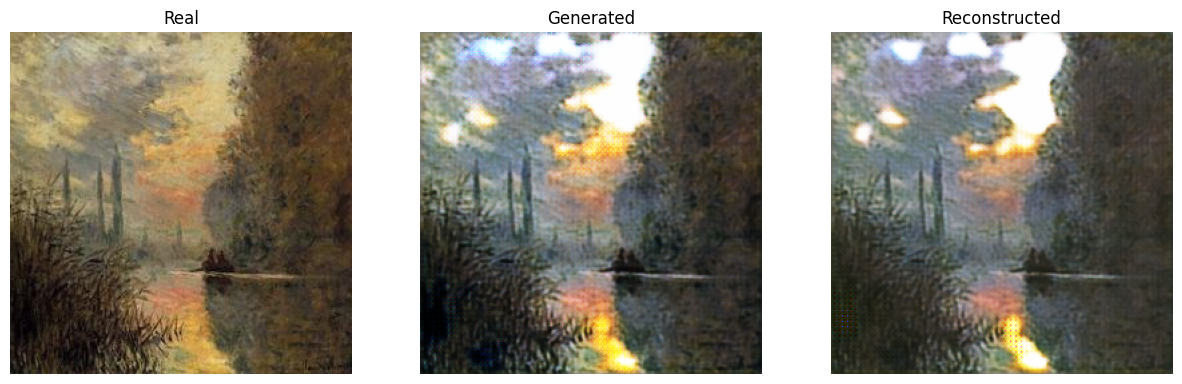

1/1 [==============================] - 0s 27ms/step


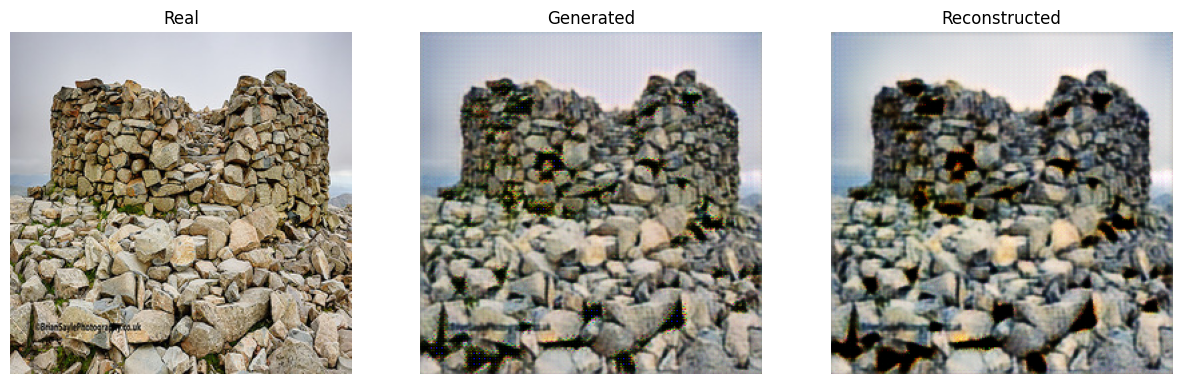

In [ ]:
# plot A -> B -> A (monet to photo to monet)

A_real= select_sample(A_data,1)
B_generated = model_AtoB .predict(A_real)
A_reconstructed= model_BtoA.predict(B_generated)

show_plot(A_real, B_generated, A_reconstructed)


# plot B -> A -> B (monet to photo to monet)

B_real= select_sample(B_data,1)
A_generated= model_BtoA.predict(B_real)
B_reconstructed= model_AtoB.predict(A_generated)

# plotting the output of the dataset
show_plot(B_real, A_generated, B_reconstructed)

Testing

In [ ]:
# function to test the trained model on random images
def test_model(test_image_path):
    #Load a single custom image
    test_image = load_img(test_image_path, target_size=(256,256))
    test_image = img_to_array(test_image)
    test_image_input = np.array([test_image])  # Convert single image to a batch.
    test_image_input = (test_image_input - 127.5) / 127.5

    # plot B->A->B (Photo to Monet to Photo)
    monet_generated  = model_BtoA.predict(test_image_input)
    photo_reconstructed = model_AtoB.predict(monet_generated)
    show_plot(test_image_input, monet_generated, photo_reconstructed)


1/1 [==============================] - 0s 25ms/step


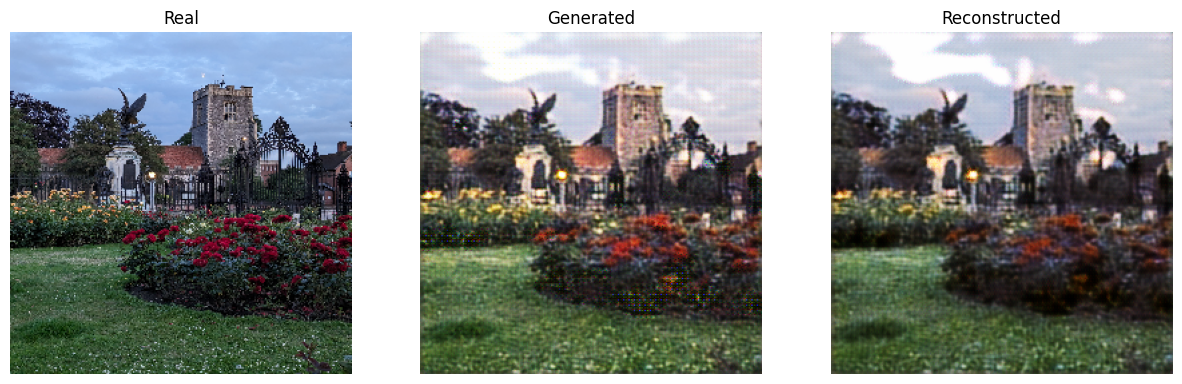

In [ ]:
#Testing the trained model for live captured images
test_model(os.path.join(path,'test1.jpg'))

1/1 [==============================] - 0s 29ms/step


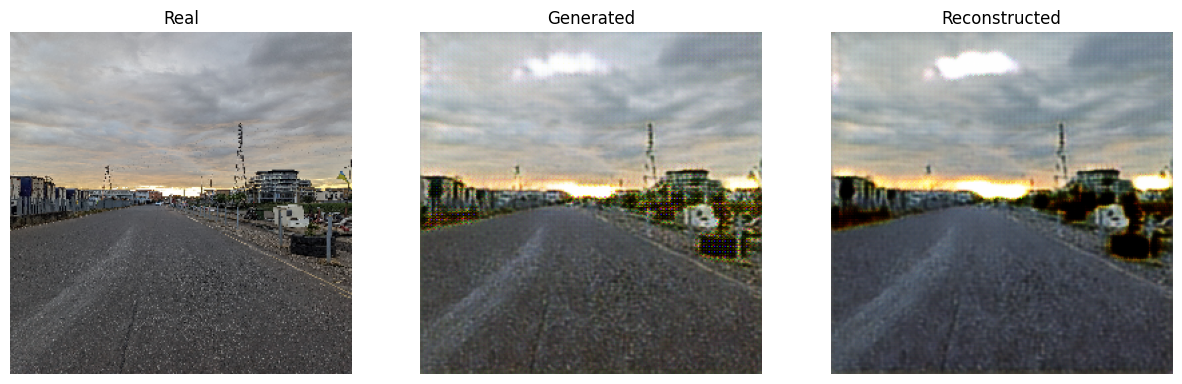

In [ ]:
#Testing the trained model for live captured images
test_model(os.path.join(path,'test2.jpg'))

1/1 [==============================] - 0s 24ms/step


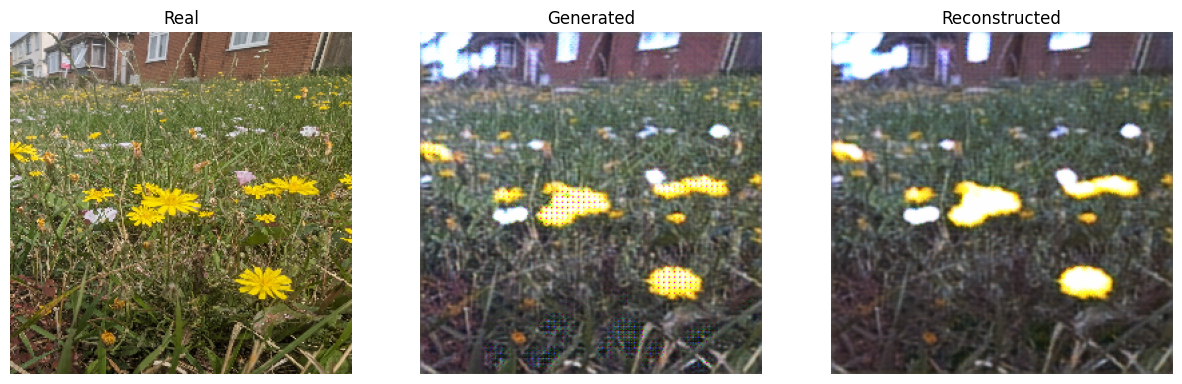

In [ ]:
#Testing the trained model for live captured images
test_model(os.path.join(path,'test3.jpg'))

1/1 [==============================] - 0s 26ms/step


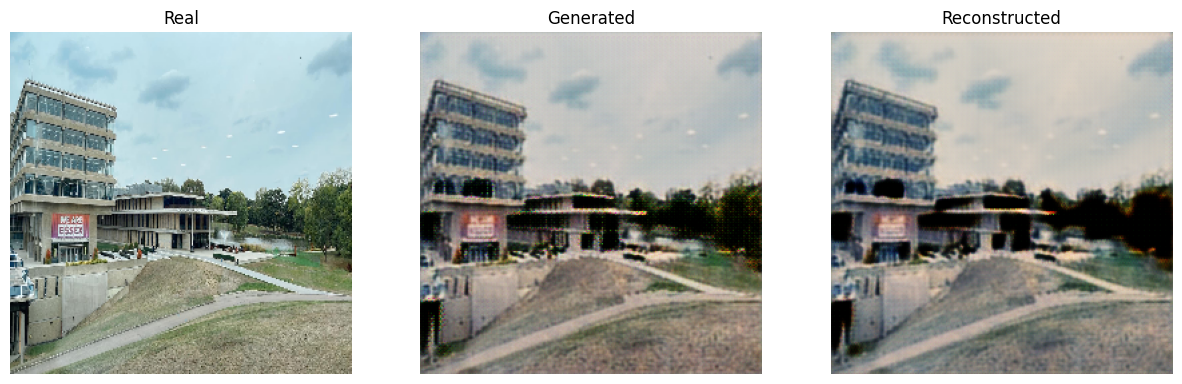

In [ ]:
#Testing the trained model for live captured images
test_model(os.path.join(path,'uni.jpg'))